In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cv2
from mpl_toolkits.axes_grid1 import ImageGrid

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

import pyClientRLagentPytorch
import utils

In [2]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#model
class DQN(nn.Module):

    def __init__(self, h, w, input_channels, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        self.x1 = F.relu(self.bn1(self.conv1(x)))
        self.x2 = F.relu(self.bn2(self.conv2(self.x1)))
        self.x3 = F.relu(self.bn3(self.conv3(self.x2)))
        return self.head(self.x3.view(self.x3.size(0), -1))


In [4]:
#utilities
def make_stack(frame, stack_size):
    stack_of_frames_initial = np.zeros((size, size, stack_size))
    for i in range(stack_size):
        stack_of_frames_initial[:,:,i] = frame
    return stack_of_frames_initial

def update_stack(stack, new_frame, stack_size):
    stack2 = stack.copy()
    for i in range(stack_size - 1):
        stack[:,:,i] = stack2[:,:,i+1].copy()
    stack[:,:,stack_size-1] = new_frame
    return stack

def select_action(state):
    return test_net(state).max(1)[1].view(1, 1)

def state_to_phosphenes(raw_state, phosphenes_input, sigma, threshold_high, threshold_low, phosphene_resolution, simulator):
    image_array = environment.state2usableArray(raw_state)    
    ksize = 11 #np.round(4*sigma)+1
    blurred = cv2.GaussianBlur(image_array,(ksize,ksize),sigma)
    canny = cv2.Canny(blurred,threshold_low,threshold_high)   
    phosphenes = simulator(activation_mask=canny)
    if phosphenes_input:
        frame = phosphenes
    else:
        frame = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)
        frame = frame.astype('float32')
    # normalize to the range 0-1
    frame /= 255.0
    return image_array, blurred, canny, phosphenes, frame

In [5]:
#hyperparameters
PHOSPHENES = False #use the phosphene representation as input or not
SIGMA = 1.2 
threshold_high = 50 
threshold_low = int(0.5 * threshold_high)
phosphene_resolution= (34,34)

size       = 128        # screenshot size
screen_height = screen_width = size

stack_size = 4

input_channels = stack_size

n_actions = 3

FOLDER = "2021-02-26_18-17_PhosFalse_Res34_FrameStacking_atari"
MODELNAME = "2021-02-26_19-21_PhosFalse_Res34_Ep270_BoxBumps5_WallBumps1_Loops0_Steps1644_TotalErrors6_Improved"
PATH = "./Models/" + FOLDER +"/"+ MODELNAME +".pth"
test_net = DQN(size, size, input_channels, n_actions).to(device)
test_net.load_state_dict(torch.load(PATH))
test_net.eval()
summary(test_net, (input_channels, size, size))

steps_done = 0

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 62, 62]           1,616
       BatchNorm2d-2           [-1, 16, 62, 62]              32
            Conv2d-3           [-1, 32, 29, 29]          12,832
       BatchNorm2d-4           [-1, 32, 29, 29]              64
            Conv2d-5           [-1, 32, 13, 13]          25,632
       BatchNorm2d-6           [-1, 32, 13, 13]              64
            Linear-7                    [-1, 3]          16,227
Total params: 56,467
Trainable params: 56,467
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.25
Forward/backward pass size (MB): 1.43
Params size (MB): 0.22
Estimated Total Size (MB): 1.90
----------------------------------------------------------------


In [6]:
# Unity environment
ip         = "127.0.0.1" # Ip address that the TCP/IP interface listens to
port       = 13000       # Port number that the TCP/IP interface listens to
timescale  = 1           # update step scale for unity

screen_height = screen_width = size

environment = pyClientRLagentPytorch.Environment(ip = ip, port = port, size = size, timescale = timescale) 

In [7]:
test_episodes = 5


simulator = utils.phosphene_simulator(phosphene_resolution, (screen_height, screen_width)) 
end, reward, state_raw = environment.reset() #resets the test environment and the first time also sets the random seed
original, blurred, canny, phosphene_frame, frame = state_to_phosphenes(state_raw, PHOSPHENES, SIGMA, threshold_high, threshold_low, phosphene_resolution, simulator)
stack_of_frames = make_stack(frame, stack_size)
state = stack_of_frames.transpose((2, 0, 1))
state = torch.from_numpy(state).unsqueeze(0).to(device, dtype=torch.float)
    
for i in range(4):
    # Select and perform an action
    action = select_action(state)
    move = action.item()
    end, reward, next_state_raw = environment.step(move)
    original, blurred, canny, phosphene_frame, next_frame = state_to_phosphenes(next_state_raw, PHOSPHENES, SIGMA, threshold_high, threshold_low, phosphene_resolution, simulator)
    stack_of_frames = update_stack(stack_of_frames, next_frame, stack_size)
    state = stack_of_frames.transpose((2, 0, 1))
    state = torch.from_numpy(state).unsqueeze(0).to(device, dtype=torch.float)
                



In [8]:
x1_np=torch.squeeze(test_net.x1).detach().cpu().numpy()
x2_np=torch.squeeze(test_net.x2).detach().cpu().numpy()
x3_np=torch.squeeze(test_net.x3).detach().cpu().numpy()

print(x1_np.shape)
print(x2_np.shape)
print(x3_np.shape)

(16, 62, 62)
(32, 29, 29)
(32, 13, 13)


In [9]:
print(x1_np[0].shape)

(62, 62)


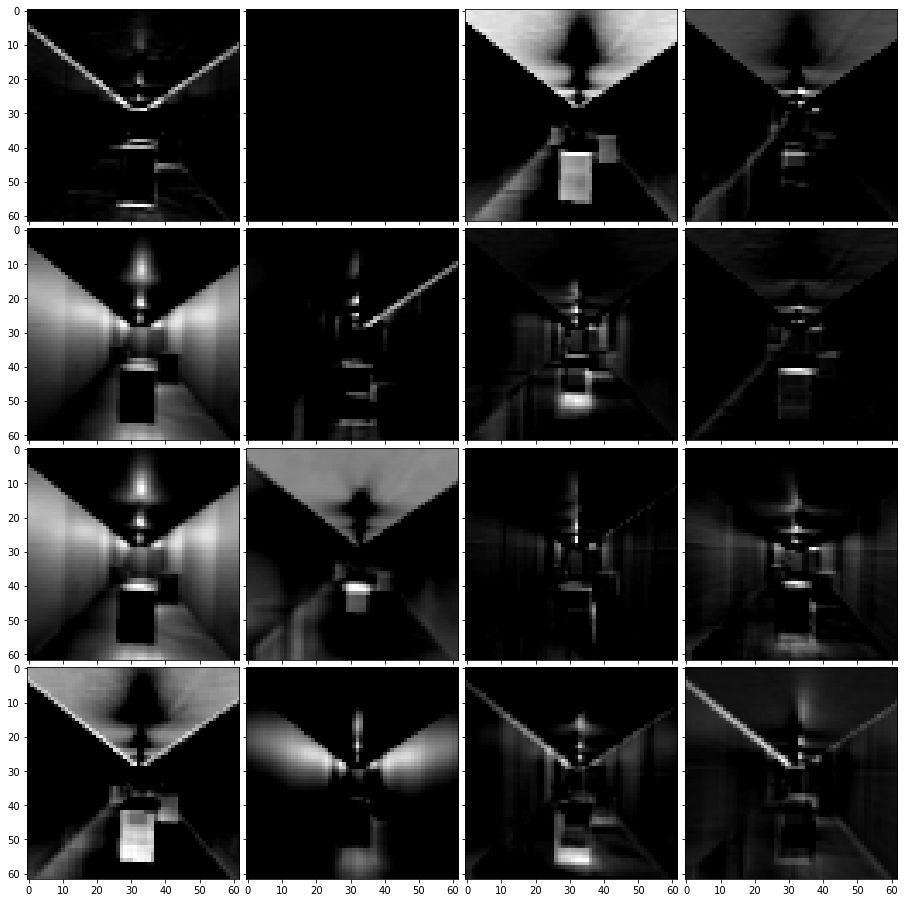

In [10]:
fig = plt.figure(figsize=(16., 16.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
#plt.imshow((x1_np[4]), cmap='gray')

for ax, im in zip(grid, x1_np):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap='gray')

plt.show()

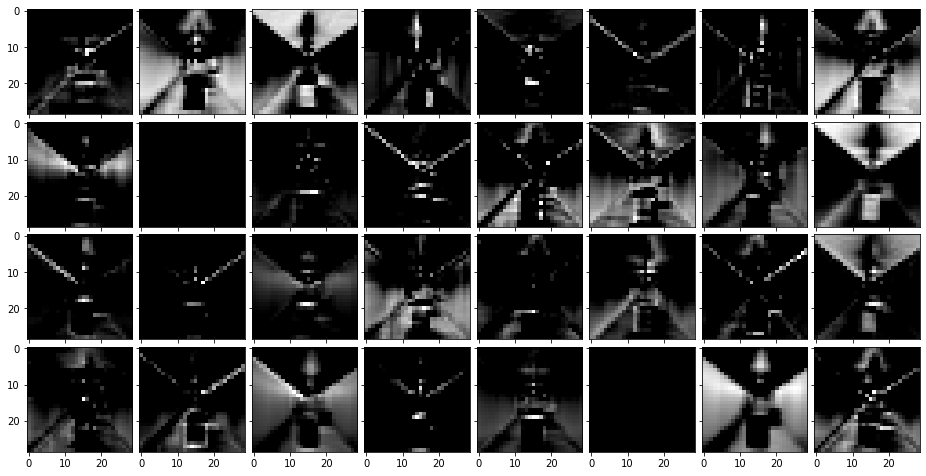

In [11]:
fig = plt.figure(figsize=(16., 16.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
#plt.imshow((x1_np[4]), cmap='gray')

for ax, im in zip(grid, x2_np):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap='gray')

plt.show()

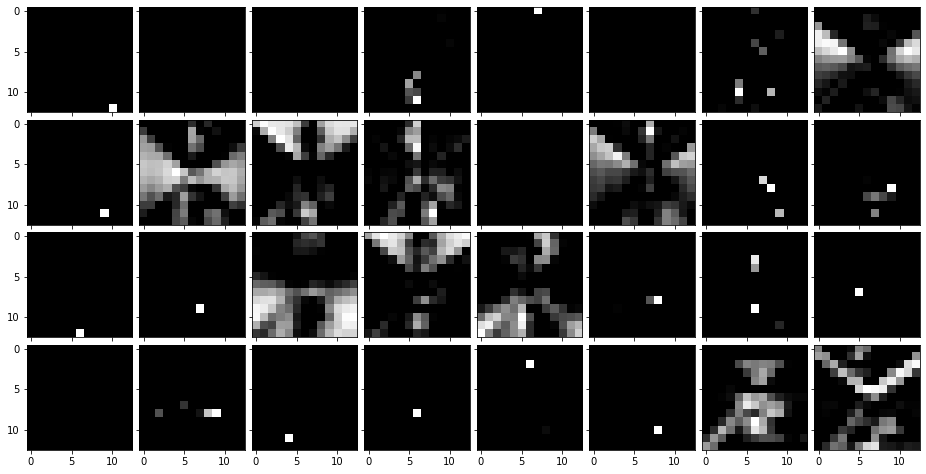

In [12]:
fig = plt.figure(figsize=(16., 16.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
#plt.imshow((x1_np[4]), cmap='gray')

for ax, im in zip(grid, x3_np):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap='gray')

plt.show()